In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from lifelines import WeibullAFTFitter,LogNormalAFTFitter,LogLogisticAFTFitter
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

In [21]:
##导入intro处理后的csv文件，并转换成pandas dataframe以进行后续的处理
from pyspark.sql import SparkSession
from pyspark import SparkConf
conf = SparkConf().setAppName("Project Q2").set("spark.jars", "/data/lab/mysql-connector-j-8.4.0.jar")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

silver_path = "silver_data.csv"
telco_pd = spark.read.format('csv').option('header','true').load(silver_path).toPandas()

In [22]:
##把选中的列转换为独热变量，将分类变量的各个类拆分成不同列，类型为True，False判断
encode_cols = ['partner','multipleLines','internetService','onlineSecurity', 'onlineBackup','deviceProtection','techSupport','paymentMethod']

encoded_pd = pd.get_dummies(telco_pd,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)

In [26]:
##提取需要的列，用于后续分析
survival_pd = encoded_pd[['churn','tenure','partner_Yes', 'multipleLines_Yes', \
                          'internetService_DSL','onlineSecurity_Yes','onlineBackup_Yes','deviceProtection_Yes','techSupport_Yes',\
                          'paymentMethod_Bank transfer (automatic)','paymentMethod_Credit card (automatic)' ]]

##初始化一个aft模型，并对于survival_pd进行拟合（分析时间相关的风险变化）
##疑问：是否可以通过aft的生存时间T概率密度函数分析组间差异？
aft = LogLogisticAFTFitter()
aft.fit(survival_pd, duration_col='tenure', event_col='churn')
##打印拟合模型数据和性质，判断差异是否显著等
print("Median Survival Time:{:.2f}".format(np.exp(aft.median_survival_time_)))
aft.print_summary()

Median Survival Time:135.51


<lifelines.LogLogisticAFTFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 3351
number of events observed = 1556
           log-likelihood = -6838.36
         time fit was run = 2025-04-12 15:09:56 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                                
alpha_ deviceProtection_Yes                     0.48      1.62      0.07            0.35            0.62                1.41                1.86
       internetService_DSL                      0.38      1.47      0.08            0.23            0.53                1.26                1.71
       multipleLines_Yes                        0.66      1.94      0.07            0.53            0.80                1.70                2.22
       onlineBackup_Yes                         0.81      2.25      0.07            0.68            0.95                1.97                2.59
       onlineSecurity_Yes                       0.86      2.37      0.09            0.69            1.03                2.00                2.80
       partner_Yes                              0.68      1.97      0.07            0.55            0.81                1.73                2.24
       paymentMethod_Bank transfer (automatic)  0.74      2.10      0.09            0.56            0.92                1.75                2.51
       paymentMethod_Credit card (automatic)    0.80      2.22      0.10            0.61            0.99                1.84                2.68
       techSupport_Yes                          0.69      1.99      0.09            0.52            0.86                1.68                2.36
       Intercept                                1.59      4.91      0.07            1.46            1.72                4.32                5.58
beta_  Intercept                                0.12      1.13      0.02            0.08            0.16                1.08                1.17

                                                cmp to     z      p  -log2(p)
param  covariate                                                             
alpha_ deviceProtection_Yes                       0.00  6.88 <0.005     37.25
       internetService_DSL                        0.00  4.98 <0.005     20.59
       multipleLines_Yes                          0.00  9.64 <0.005     70.70
       onlineBackup_Yes                           0.00 11.63 <0.005    101.50
       onlineSecurity_Yes                         0.00 10.12 <0.005     77.60
       partner_Yes                                0.00 10.21 <0.005     78.93
       paymentMethod_Bank transfer (automatic)    0.00  8.05 <0.005     50.07
       paymentMethod_Credit card (automatic)      0.00  8.36 <0.005     53.81
       techSupport_Yes                            0.00  7.90 <0.005     48.37
       Intercept                                  0.00 24.47 <0.005    436.88
beta_  Intercept                                  0.00  5.71 <0.005     26.42
---
Concordance = 0.73
AIC = 13698.72
log-likelihood ratio test = 877.49 on 9 df
-log2(p) of ll-ratio test = 605.78

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

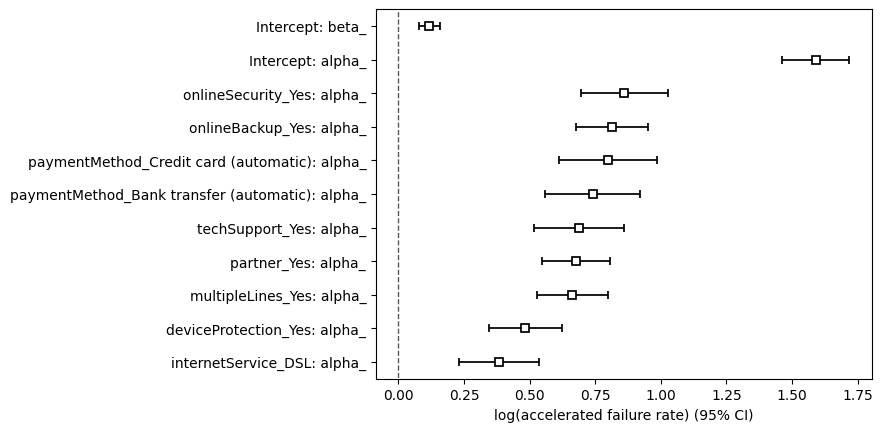

In [27]:
aft.plot()

In [24]:
##同第二题的kmf模型
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
telco_pd['tenure'] = pd.to_numeric(telco_pd['tenure'], errors='coerce')
T=telco_pd['tenure']
C=telco_pd['churn'].astype(float)
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

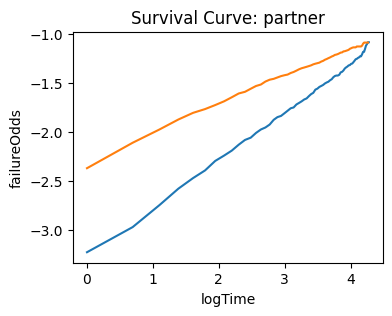

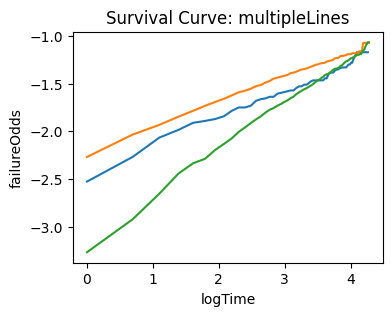

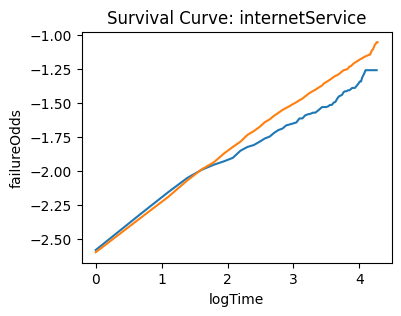

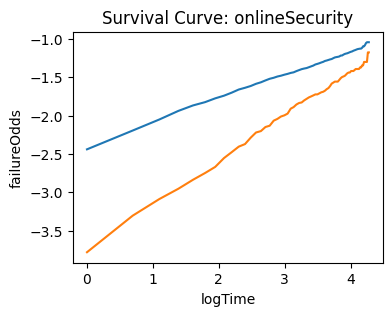

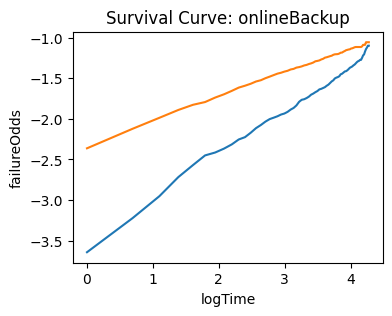

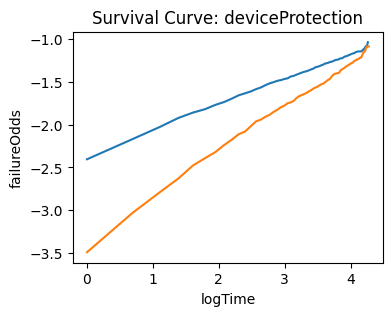

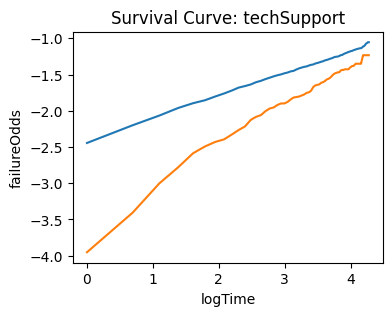

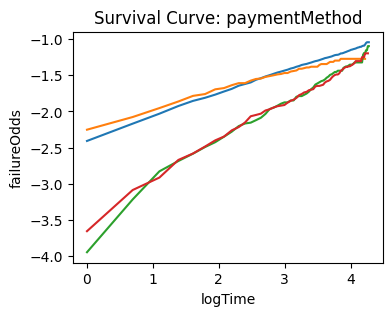

In [25]:
import matplotlib.pyplot as plt

def plot_km_logOdds(col):
  fig, ax = plt.subplots(figsize=(4,3))
  for r in telco_pd[col].unique():
    ix = telco_pd[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    sf = kmf.survival_function_
    sf['failureOdds'] = (np.log(1-sf))/sf
    sf['logTime'] = np.log(sf.index)
    plt.plot(sf['logTime'],sf['failureOdds'])
    plt.title(f'Survival Curve: {col}')
    plt.xlabel('logTime')
    plt.ylabel('failureOdds')

plot_km_logOdds('partner')
plot_km_logOdds('multipleLines')
plot_km_logOdds('internetService')
plot_km_logOdds('onlineSecurity')
plot_km_logOdds('onlineBackup')
plot_km_logOdds('deviceProtection')
plot_km_logOdds('techSupport')
plot_km_logOdds('paymentMethod')